In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # using seaborn because the charts are more visually pleasing


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/financial/BrentOilPrices.csv')
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


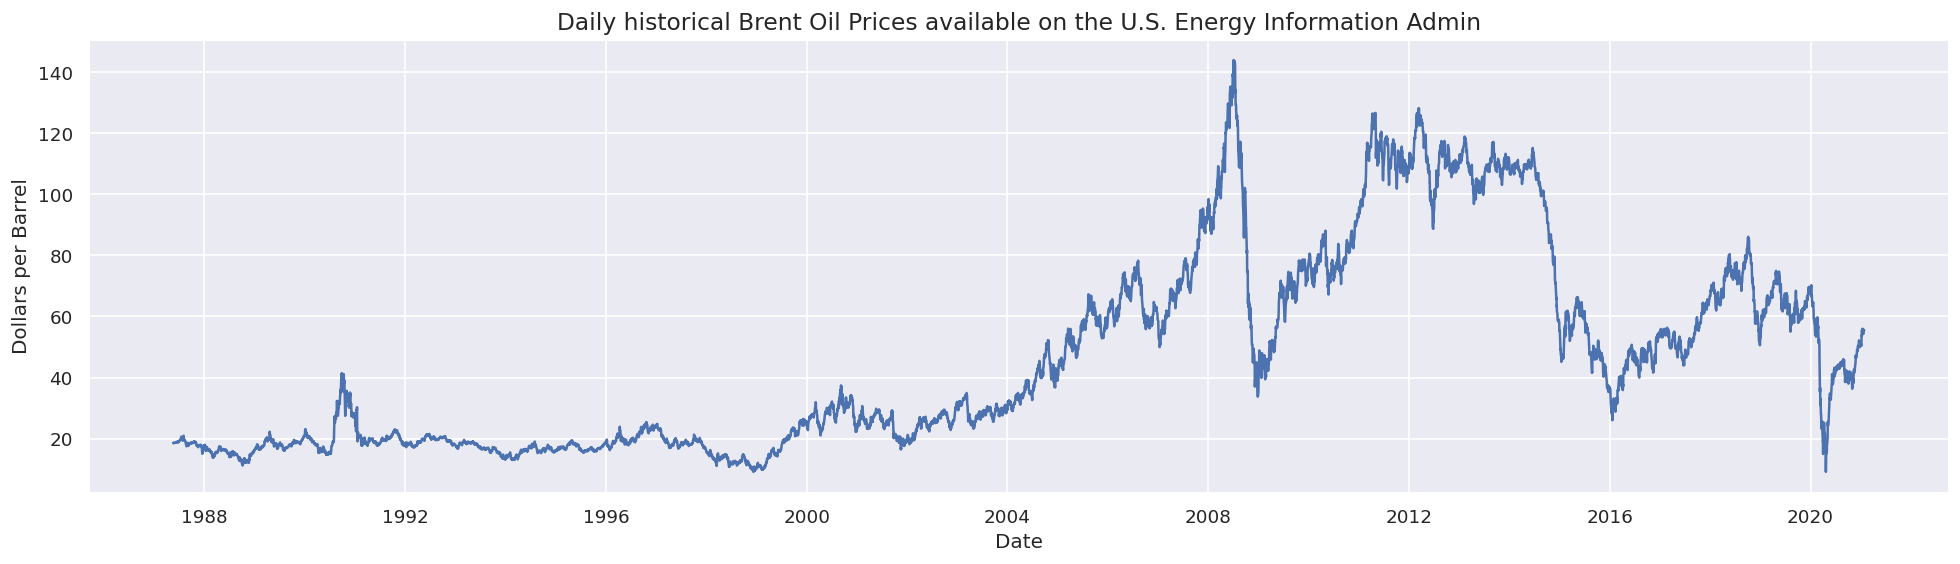

In [ ]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20,5))
sns.lineplot(x="Date", y="Price", data=df)
plt.title('Daily historical Brent Oil Prices available on the U.S. Energy Information Admin', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.show()

In [ ]:
df.describe()

,Price
count,8554.000000
mean,46.352962
std,32.165282
min,9.100000
25%,18.850000
50%,33.240000
75%,66.210000
max,143.950000


In [ ]:
# Creating a simple moving average for 7 and 21 days
df['ma7'] = df.Price.rolling(window=7).mean()
df['ma21'] = df.Price.rolling(window=21).mean()

In [ ]:
# Creating the EMA
df['ema12'] = df.Price.ewm(span=12).mean().fillna(0)
df['ema26'] = df.Price.ewm(span=26).mean().fillna(0)
df['macd'] = df.ema12 - df.ema26



In [ ]:
#The variables below are used for Bollinger Bands.
window=21
no_std = 2
rolling_mean = df.Price.rolling(window).mean()
rolling_std = df.Price.rolling(window).std()
df['bollinger_low'] = (rolling_mean - (rolling_std * no_std)).fillna(0)
df['bollinger_high'] = (rolling_mean + (rolling_std * no_std)).fillna(0)
df['ema'] = df.Price.ewm(com=0.5).mean()
df['momentum'] =  df.Price - 1


In [ ]:
df.head()

,Price,ma7,ma21,ema12,ema26,macd,bollinger_low,bollinger_high,ema,momentum
Date,,,,,,,,,,
1987-05-20,18.63,NaN,NaN,18.630000,18.630000,0.000000,0.0,0.0,18.630000,17.63
1987-05-21,18.45,NaN,NaN,18.532500,18.536538,-0.004038,0.0,0.0,18.495000,17.45
1987-05-22,18.55,NaN,NaN,18.539330,18.541375,-0.002045,0.0,0.0,18.533077,17.55
1987-05-25,18.60,NaN,NaN,18.558481,18.557764,0.000717,0.0,0.0,18.578250,17.60
1987-05-26,18.63,NaN,NaN,18.577913,18.574516,0.003397,0.0,0.0,18.612893,17.63


Machine Learning

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(df.Price.values.reshape(-1, 1))
dataset[0:10]

array([[0.07067112],
       [0.0693363 ],
       [0.07007786],
       [0.07044865],
       [0.07067112],
       [0.07044865],
       [0.07044865],
       [0.07030033],
       [0.07081943],
       [0.0710419 ]])

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
f'Dataset size: {len(df)} >> Train length: {len(train)} || Test Length: {len(test)}'

'Dataset size: 8554 >> Train length: 5987 || Test Length: 2567'

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)
f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
y_test: {y_test.shape}'

'X_train: (5971, 15) || y_train: (5971,) || X_test: (2551, 15) || y_test: (2551,)'

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
y_test: {y_test.shape}'

'X_train: (5971, 1, 15) || y_train: (5971,) || X_test: (2551, 1, 15) || y_test: (2551,)'

LSTM

In [ ]:
# create and fit the LSTM network
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
5971/5971 - 14s - loss: 7.3099e-04 - 14s/epoch - 2ms/step
Epoch 2/20
5971/5971 - 10s - loss: 1.9607e-04 - 10s/epoch - 2ms/step
Epoch 3/20
5971/5971 - 11s - loss: 1.5983e-04 - 11s/epoch - 2ms/step
Epoch 4/20
5971/5971 - 11s - loss: 1.4796e-04 - 11s/epoch - 2ms/step
Epoch 5/20
5971/5971 - 12s - loss: 1.2600e-04 - 12s/epoch - 2ms/step
Epoch 6/20
5971/5971 - 11s - loss: 1.3247e-04 - 11s/epoch - 2ms/step
Epoch 7/20
5971/5971 - 10s - loss: 1.2099e-04 - 10s/epoch - 2ms/step
Epoch 8/20
5971/5971 - 10s - loss: 1.1604e-04 - 10s/epoch - 2ms/step
Epoch 9/20
5971/5971 - 11s - loss: 1.2247e-04 - 11s/epoch - 2ms/step
Epoch 10/20
5971/5971 - 11s - loss: 1.0690e-04 - 11s/epoch - 2ms/step
Epoch 11/20
5971/5971 - 11s - loss: 1.0776e-04 - 11s/epoch - 2ms/step
Epoch 12/20
5971/5971 - 10s - loss: 1.0409e-04 - 10s/epoch - 2ms/step
Epoch 13/20
5971/5971 - 14s - loss: 1.0249e-04 - 14s/epoch - 2ms/step
Epoch 14/20
5971/5971 - 11s - loss: 9.7590e-05 - 11s/epoch - 2ms/step
Epoch 15/20
5971/5971 - 11s -

In [ ]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.20 RMSE
Test Score: 1.86 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


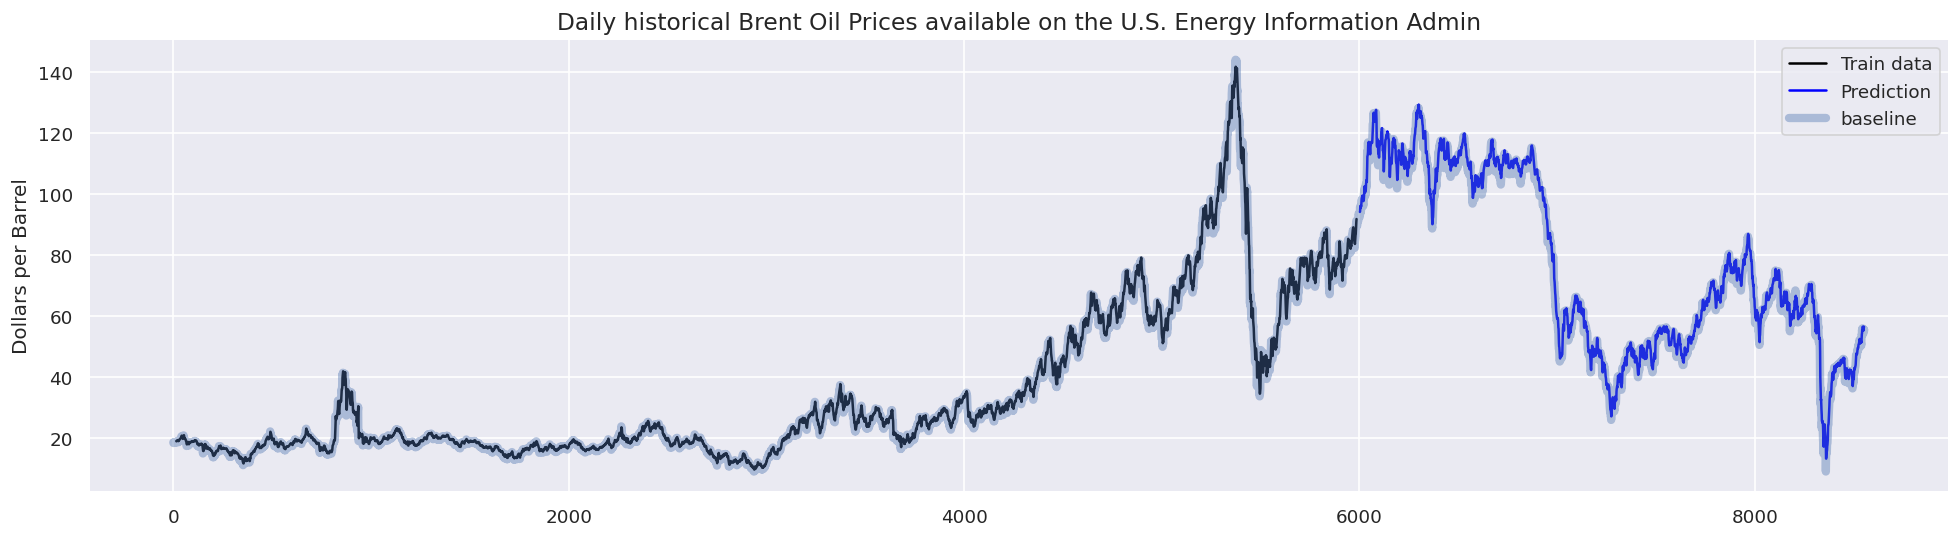

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color='black', label='Train data')
plt.plot(testPredictPlot, color='blue', label='Prediction',)
plt.plot(min_max_scaler.inverse_transform(dataset),label='baseline', alpha=0.4, linewidth=5)
plt.title('Daily historical Brent Oil Prices available on the U.S. Energy Information Admin', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.legend()
plt.show()

In [ ]:
import pandas as pd 

In [ ]:

#import the csv file
oilPrices = pd.read_csv('/content/drive/MyDrive/financial/BrentOilPrices.csv')
#change column names to more comfortable names
oilPrices.columns=['date', 'price']
#Cast Date Column to type date
oilPrices['date'] = pd.to_datetime(oilPrices['date'])
print("Data Set:"% oilPrices.columns, oilPrices.shape)
print("Data Types:", oilPrices.dtypes)
#Check the top five records
oilPrices.head()

Data Set: (8554, 2)
Data Types: date     datetime64[ns]
price           float64
dtype: object


,date,price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [ ]:
oilPrices.set_index('date', inplace=True)
oilPrices = oilPrices.resample('D').ffill().reset_index()

In [ ]:
oilPrices.isnull().values.any()

False

In [ ]:
oilPrices['year']=oilPrices['date'].dt.year
oilPrices['month']=oilPrices['date'].dt.month
oilPrices['week']=oilPrices['date'].dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train = oilPrices[(oilPrices['date' ] > '2000-01-01') & (oilPrices['date' ] <= '2018-12-31')]
test = oilPrices[oilPrices['date' ] >= '2019-01-01']

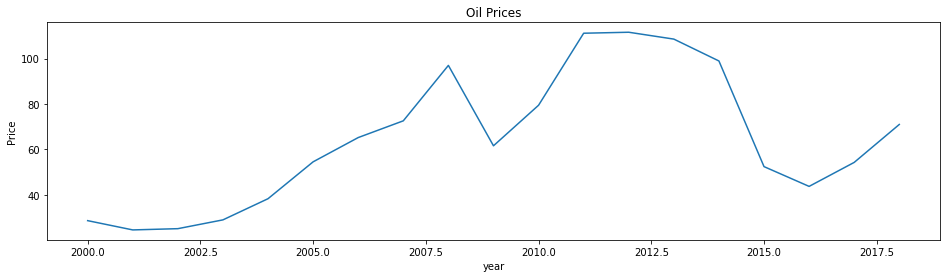

In [ ]:
yearlyPrice=train.groupby(["year"])['price'].mean()
plt.figure(figsize=(16,4))
plt.title('Oil Prices')
plt.xlabel('Year')
plt.ylabel('Price')
yearlyPrice.plot()
plt.show();

ARIMA


In [ ]:
#Convert to Time Series For ARIMA Estimator
series=pd.Series(data=train['price'].to_numpy(), index=train['date'])

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic: -2.000744
p-value: 0.286247


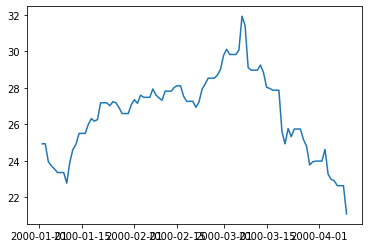

In [ ]:
plt.plot(series[0:100])
plt.show()


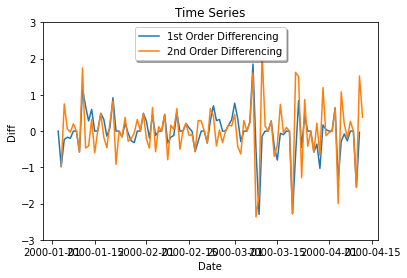

In [ ]:
daily_series_diff1 = series.diff(periods=1).dropna()
daily_series_diff2 = daily_series_diff1.diff(periods=1).dropna()
fig, ax = plt.subplots()
ax.plot(daily_series_diff1[0:100], label='1st Order Differencing')
ax.plot(daily_series_diff2[0:100], label='2nd Order Differencing')
plt.ylim([-3,3])
legend = ax.legend(loc='upper center', shadow=True)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Diff')
plt.show()


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

In [ ]:
!pip install pyramid

In [ ]:
!pip install pmdarima

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
y=series

The Order of Autoregressive Term P

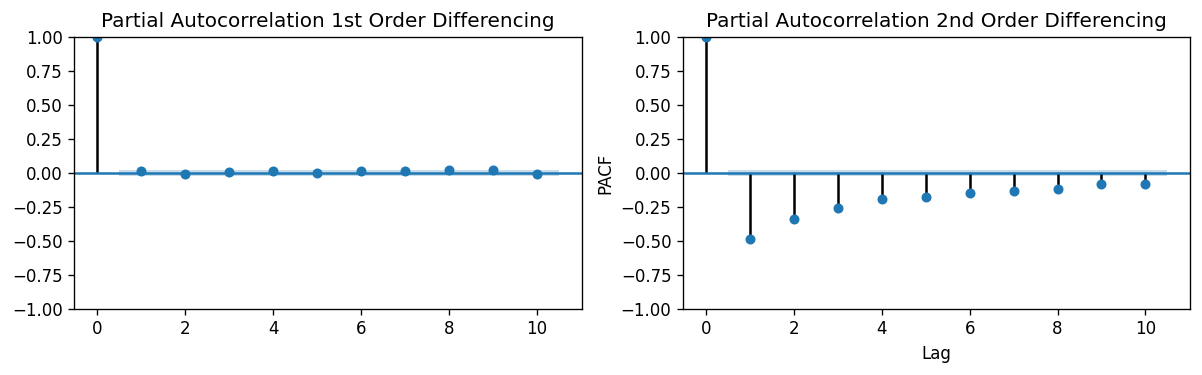

In [ ]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1, 2, sharex=True)
plot_pacf(daily_series_diff1, lags=10, ax=axes[0], title="Partial Autocorrelation 1st Order Differencing")
plot_pacf(daily_series_diff2, lags=10, ax=axes[1], title="Partial Autocorrelation 2nd Order Differencing")
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series, order=(1, 0, 1)).fit(transparams=False)
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 6939
Model:                     ARMA(1, 1)   Log Likelihood              -10505.877
Method:                       css-mle   S.D. of innovations                nan
Date:                Thu, 05 May 2022   AIC                          21019.753
Time:                        20:47:04   BIC                          21047.133
Sample:                    01-02-2000   HQIC                         21029.192
                         - 12-31-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.4434     17.961      3.866      0.000      34.241     104.646
ar.L1.y        0.9992      0.000   2088.289      0.000       0.998       1.000
ma.L1.y        0.0147      0.012      1.208      0.2

In [ ]:
ARIMA_Predict = model.predict(start='1/1/2019', end='9/30/2019')

The Prophet Model

In [ ]:
from fbprophet import Prophet
d={'ds':train['date'],'y':train['price']}
df_pred=pd.DataFrame(data=d)
model = Prophet(daily_seasonality=False)
model.fit(df_pred)

<Figure size 2160x720 with 0 Axes>

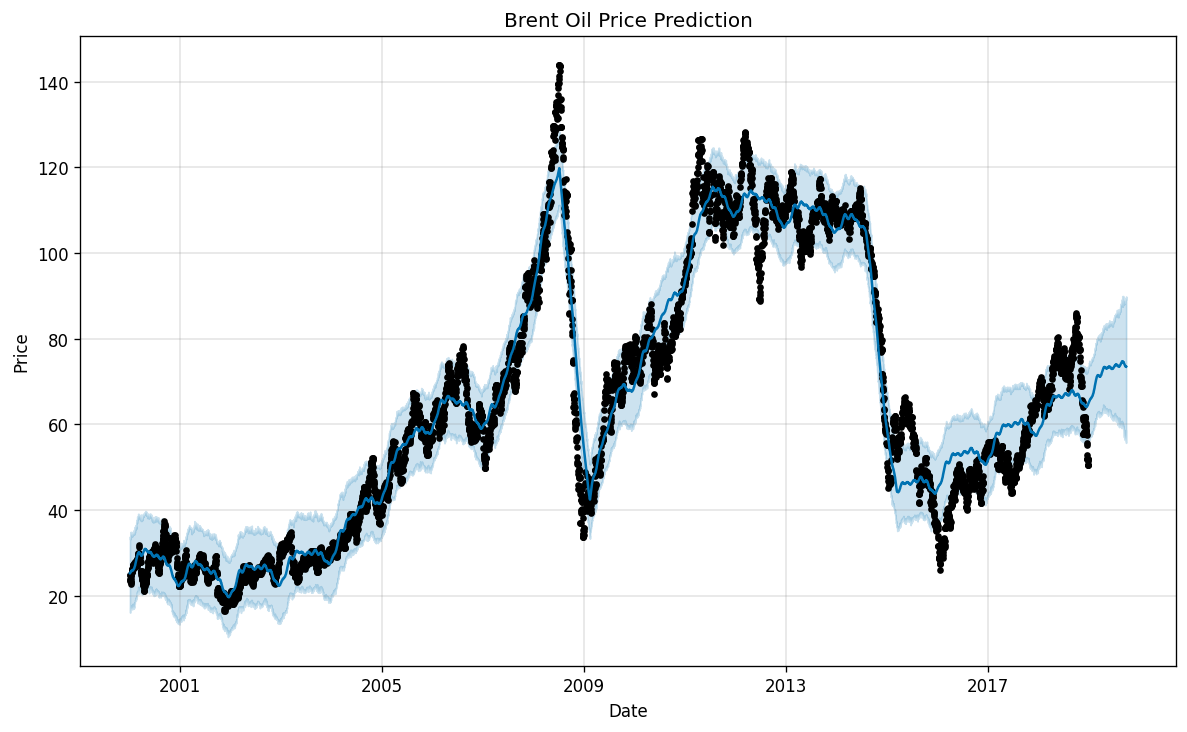

In [ ]:
future = model.make_future_dataframe(periods=273)
forecast = model.predict(future)
plt.figure(figsize=(18, 6))
model.plot(forecast, xlabel = 'Date', ylabel = 'Price')
plt.title('Brent Oil Price Prediction');

In [ ]:
forecast2019 = forecast[(forecast['ds' ] >= '2019-01-01') & (forecast['ds' ] <= '2019-09-30')]

Evaluation

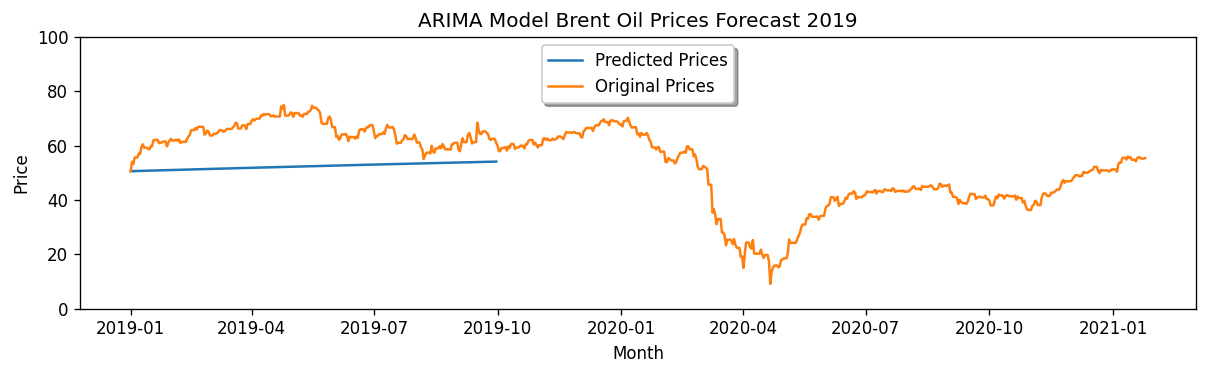

In [ ]:
fig, ax = plt.subplots()
ax.plot(forecast2019['ds'], ARIMA_Predict, label='Predicted Prices')
ax.plot(test['date'], test['price'], label='Original Prices')
plt.ylim([0,100])
legend = ax.legend(loc='upper center', shadow=True)
plt.title('ARIMA Model Brent Oil Prices Forecast 2019')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

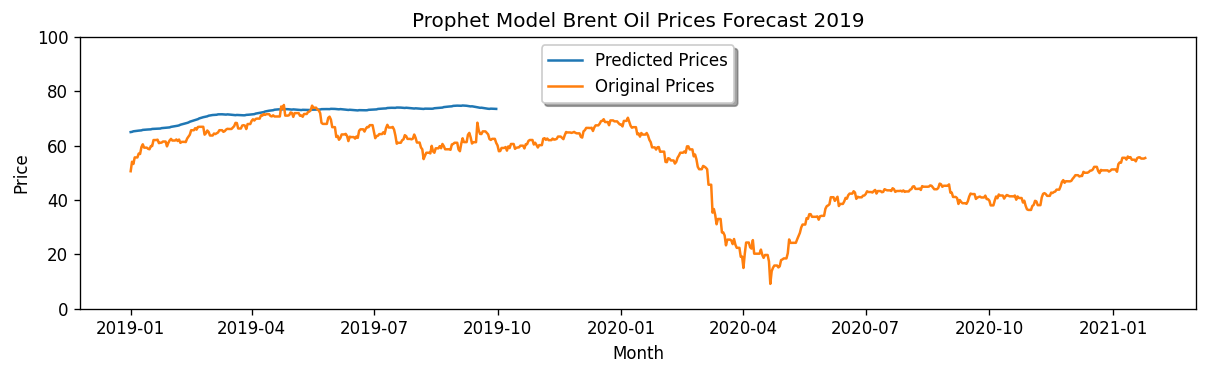

In [ ]:
fig, ax = plt.subplots()
ax.plot(forecast2019['ds'], forecast2019['yhat'], label='Predicted Prices')
ax.plot(test['date'], test['price'], label='Original Prices')
plt.ylim([0,100])
legend = ax.legend(loc='upper center', shadow=True)
plt.title('Prophet Model Brent Oil Prices Forecast 2019')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()